# fMRI6a -- Compute the actflow decodability of Motor responses (LINDEX v. LMID and RINDEX v. RMID)
## Using EigenActFlow using PCA regression
# Within subjects

## Takuya Ito
#### 2/22/2019

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
import nibabel as nib
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import sklearn.svm as svm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
from sklearn.feature_selection import f_classif
import seaborn as sns
import h5py
os.sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import statsmodels.api as sm
import sys
sys.path.append('utils/')
import loadExperimentalData as led
import tools

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [6]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']

basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# 0.0 Define functions for loading data

## 0.1 Load data

In [39]:
tools = reload(tools)

In [12]:
# gsr = True
nTrials = 384
data_task = np.zeros((len(glasser2),nTrials,len(subjNums)))

scount = 0
for subj in subjNums:
    if scount%4==0: print 'Loading subject', scount, '/', len(subjNums)
    data_task[:,:,scount] = tools.loadMotorResponses(subj)
    scount += 1

Loading subject 0 / 96
Loading subject 4 / 96
Loading subject 8 / 96
Loading subject 12 / 96
Loading subject 16 / 96
Loading subject 20 / 96
Loading subject 24 / 96
Loading subject 28 / 96
Loading subject 32 / 96
Loading subject 36 / 96
Loading subject 40 / 96
Loading subject 44 / 96
Loading subject 48 / 96
Loading subject 52 / 96
Loading subject 56 / 96
Loading subject 60 / 96
Loading subject 64 / 96
Loading subject 68 / 96
Loading subject 72 / 96
Loading subject 76 / 96
Loading subject 80 / 96
Loading subject 84 / 96
Loading subject 88 / 96
Loading subject 92 / 96


# 1.0 Define functions for motor response decodings

## 1.1 Run actflow and decoding analyses

In [85]:
tools = reload(tools)

In [121]:
nproc = 20
n_components_include = 100
ncvs = 10

roi_rh = 9
roi_lh = 189
# roi_rh = 8
# roi_lh = 188

roi_rh_ind = np.where(glasser2==roi_rh)[0]
roi_lh_ind = np.where(glasser2==roi_lh)[0]

dilateLH = tools.loadMask(roi_lh,dilated=True)
dilateRH = tools.loadMask(roi_rh,dilated=True)
combinedDilated = dilateLH + dilateRH
# combinedDilated = dilateRH
# Exclude all SMN regions
smn_rois = np.where(networkdef==networkmappings['smn'])[0]
for x in smn_rois:
    roi_ind = np.where(glasser2==x)[0]
    combinedDilated[roi_ind]=1
all_source_ind = np.where(combinedDilated==0)[0]

source_rois = []
source_rois.extend(np.where(networkdef==networkmappings['fpn'])[0])
source_rois.extend(np.where(networkdef==networkmappings['con'])[0])
source_rois.extend(np.where(networkdef==networkmappings['dan'])[0])

actflow_data_rh = np.zeros((len(roi_rh_ind),data_task.shape[1],len(source_rois),len(subjNums))) # n vertices for target region, n miniblocks, n source regions, n subjects
actflow_data_lh = np.zeros((len(roi_lh_ind),data_task.shape[1],len(source_rois),len(subjNums)))

accuracies_rh = np.zeros((len(source_rois),len(subjNums)))
accuracies_lh = np.zeros((len(source_rois),len(subjNums)))

scount = 0
for subj in subjNums:
    print 'Run analysis for subject', subj, '(', scount + 1, '/', len(subjNums), ')'
    print '\tLoad PCA_FC...'
    fcmapping_rh = tools.loadPcaFCNoColliders(subj,roi_rh)
    fcmapping_lh = tools.loadPcaFCNoColliders(subj,roi_lh)
    
    inputs_lh = []
    inputs_rh = []
        
    print '\tPerform actflow in brain space...'
    roicount = 0
    for roi in source_rois:
        roi_ind = np.where(glasser2==roi+1)[0]
        source_ind = np.intersect1d(roi_ind,all_source_ind)
        
        # Find ROI ind for reduced fc mapping (since it doesn't include all vertices)
        fc_roi_ind = np.where(glasser2[source_ind]==roi+1)[0]
#         # Right Finger 1
#         actflow_data_rh[:,:,roicount,scount] = np.dot(data_task[source_ind,:,scount].T,fcmapping_rh[fc_roi_ind,:]).T
#         # Right Finger 2:
#         actflow_data_lh[:,:,roicount,scount] = np.dot(data_task[source_ind,:,scount].T,fcmapping_lh[fc_roi_ind,:]).T
        # Right Finger 1
        actflow_data_rh[:,:,roicount,scount] = np.dot(stats.zscore(data_task[source_ind,:,scount],axis=0).T,fcmapping_rh[fc_roi_ind,:]).T
        # Right Finger 2:
        actflow_data_lh[:,:,roicount,scount] = np.dot(stats.zscore(data_task[source_ind,:,scount],axis=0).T,fcmapping_lh[fc_roi_ind,:]).T

        # Gather real target data
        data_rh = stats.zscore(data_task[roi_rh_ind,:,scount],axis=0)
        data_lh = stats.zscore(data_task[roi_lh_ind,:,scount],axis=0)
#         data_rh = data_task[roi_rh_ind,:,scount]
#         data_lh = data_task[roi_lh_ind,:,scount]
    #     actflow_data_rh[:,:,scount] = stats.zscore(actflow_data_rh[:,:,scount],axis=0)
    #     actflow_data_lh[:,:,scount] = stats.zscore(actflow_data_lh[:,:,scount],axis=0)

        accuracies_rh[roicount,scount] = tools.motorResponseDecodings((data_rh,actflow_data_rh[:,:,roicount,scount],subj,'right',ncvs))
        accuracies_lh[roicount,scount] = tools.motorResponseDecodings((data_lh,actflow_data_lh[:,:,roicount,scount],subj,'left',ncvs))
        
        roicount += 1
    
    scount += 1
    

Run analysis for subject 013 ( 1 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...


/home/tito/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/tito/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:68: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/tito/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/tito/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/tito/miniconda2/lib/python2.7/site-packages/numpy/core/_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Run analysis for subject 014 ( 2 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 016 ( 3 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 017 ( 4 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 018 ( 5 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 021 ( 6 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 023 ( 7 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 024 ( 8 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 026 ( 9 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 027 ( 10 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 028 ( 11 / 96 )
	Load PCA_FC...
	Perform actflow in brain space...
Run analysis for subject 030 ( 12 / 96 )
	Load PCA_FC...
	Perform actflow in brain space

## 1.2 Compute right-hand response statistics

In [122]:
statistics_rh = np.zeros((len(source_rois),3)) # acc, t, qs
ps = []
for i in range(len(source_rois)):
    t, p = stats.ttest_1samp(accuracies_rh[i,:],0.5)
    if t>0:
        p = p/2.0
    else:
        p = 1.0-p/2.0
    ps.append(p)
    
    statistics_rh[i,0] = np.mean(accuracies_rh[i,:])
    statistics_rh[i,1] = t

qs = mc.fdrcorrection0(ps)[1]
for i in range(len(source_rois)):
    statistics_rh[i,2] = qs[i]
    
sig_rois = np.where(statistics_rh[:,2]<0.05)[0]
for roi in sig_rois:
    print 'ROI', source_rois[roi] + 1
    print '\tAccuracy:', statistics_rh[roi,0]
    print '\tP-value:', statistics_rh[roi,2]


Text(0.5,1,'Distribution of FDR-corrected p-values')

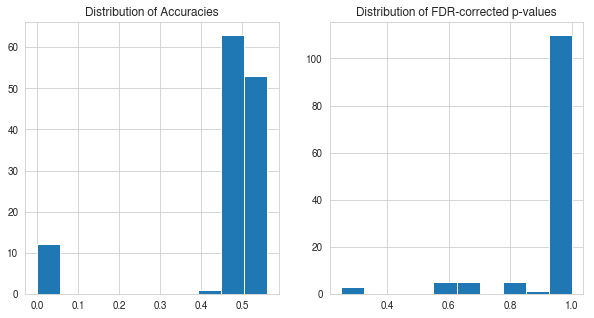

In [123]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(statistics_rh[:,0])
plt.title('Distribution of Accuracies')
plt.subplot(122)
plt.hist(statistics_rh[:,2])
plt.title('Distribution of FDR-corrected p-values')

## 1.2 Compute left-hand response statistics

In [124]:
statistics_lh = np.zeros((len(source_rois),3)) # acc, t, qs
ps = []
for i in range(len(source_rois)):
    t, p = stats.ttest_1samp(accuracies_lh[i,:],0.5)
    if t>0:
        p = p/2.0
    else:
        p = 1.0-p/2.0
    ps.append(p)
    
    statistics_lh[i,0] = np.mean(accuracies_lh[i,:])
    statistics_lh[i,1] = t

qs = mc.fdrcorrection0(ps)[1]
for i in range(len(source_rois)):
    statistics_lh[i,2] = qs[i]
    
sig_rois = np.where(statistics_lh[:,2]<0.05)[0]
for roi in sig_rois:
    print 'ROI', source_rois[roi] + 1
    print '\tAccuracy:', statistics_lh[roi,0]
    print '\tP-value:', statistics_lh[roi,2]

Text(0.5,1,'Distribution of FDR-corrected p-values')

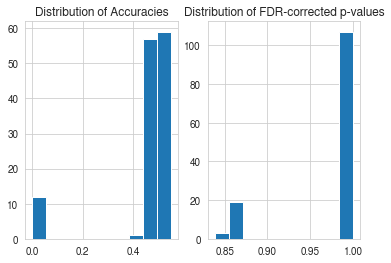

In [125]:
# plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(statistics_lh[:,0])
plt.title('Distribution of Accuracies')
plt.subplot(122)
plt.hist(statistics_lh[:,2])
plt.title('Distribution of FDR-corrected p-values')